<a href="https://colab.research.google.com/github/pepperamy/tenK_phase2/blob/main/Copy_of_10k_featureselection_allmodel_firstyear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import pickle
import re
from matplotlib import pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.optimize import linear_sum_assignment
import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import mstats
import math

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
from sklearn.model_selection import KFold,StratifiedKFold

In [8]:
from keras import regularizers

In [9]:
from keras import backend as K

In [10]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_recall_curve, classification_report,accuracy_score, auc, roc_curve, roc_auc_score, average_precision_score

In [11]:
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.layers import Embedding, Dense, Conv2D, MaxPooling2D, Reshape, Conv1D, MaxPooling1D,\
Dropout, Activation, Input, Flatten, Concatenate, BatchNormalization, Lambda, LSTM, GRU, Bidirectional,\
ZeroPadding2D
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras.models import Model
from keras import optimizers
from keras import metrics
from keras import models
from keras import layers

In [12]:
from sklearn.utils import class_weight

In [13]:
from sklearn import utils

In [14]:
import random

In [15]:
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
#from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# data prepare

In [16]:
df = pd.read_csv('data_performance_words_win1_03_firstyear.csv')

In [17]:
df.shape

(51811, 192)

In [18]:
sum(df.label)

179.0

In [19]:
df.head()

,cik,y1,y2,s1,window,label,sic_class_x,rsst_acc,ch_rec,ch_inv,soft_asset,ch_cs,ch_roa,issue,aqi,asset_turnover,cfed,depi,gmi,ig,opm,rg,sg,sgee,pastavg5,pastavg3,pastavg1,cr5,cr3,cr1,WeakModal_3_avg,WeakModal_3_dis,WeakModal_3_n,WeakModal_3_new,WeakModal_3_p,WeakModal_3_u,Litigious_3_avg,Litigious_3_dis,Litigious_3_n,Litigious_3_new,...,Differ_3_n,Differ_3_new,Differ_3_p,Differ_3_u,Drives_3_avg,Drives_3_dis,Drives_3_n,Drives_3_new,Drives_3_p,Drives_3_u,Affiliation_3_avg,Affiliation_3_dis,Affiliation_3_n,Affiliation_3_new,Affiliation_3_p,Affiliation_3_u,Achieve_3_avg,Achieve_3_dis,Achieve_3_n,Achieve_3_new,Achieve_3_p,Achieve_3_u,Power_3_avg,Power_3_dis,Power_3_n,Power_3_new,Power_3_p,Power_3_u,Reward_3_avg,Reward_3_dis,Reward_3_n,Reward_3_new,Reward_3_p,Reward_3_u,Risk_3_avg,Risk_3_dis,Risk_3_n,Risk_3_new,Risk_3_p,Risk_3_u
0,20.0,1995.0,1996.0,0.633505,1.0,0.0,3,0.063117,-0.072425,-0.067847,0.661974,-0.147079,0.198730,1,0.974056,1.624273,0.206066,1.226305,0.914198,0.715334,0.044798,0.783539,0.814093,1.013528,NaN,NaN,NaN,NaN,NaN,NaN,-0.000071,0.000000,0.095238,0.004950,0.047619,0.761905,-0.002775,0.002801,0.190476,0.000000,...,0.380952,0.004950,0.380952,0.142857,-0.007085,0.051165,0.428571,0.054325,0.285714,0.190476,0.002484,0.017475,0.095238,0.004950,0.285714,0.523810,-0.003165,0.017510,0.285714,0.013158,0.047619,0.571429,-0.004527,0.016180,0.428571,0.029638,0.285714,0.190476,-0.000009,0.002644,0.190476,0.000000,0.190476,0.523810,-0.002433,0.002488,0.333333,0.019737,0.000000,0.571429
1,20.0,1996.0,1997.0,0.803827,1.0,0.0,3,0.066126,-0.018252,-0.059281,0.620435,-0.066028,0.034753,1,1.248039,1.606518,0.025826,1.088859,0.978102,0.755016,0.062466,0.938786,0.969746,1.012432,0.633505,0.633505,0.633505,1.268856,1.268856,1.268856,-0.000034,0.000000,0.066667,0.028571,0.000000,0.866667,0.003234,0.000000,0.133333,0.000000,...,0.266667,0.028571,0.133333,0.533333,-0.004321,0.044777,0.266667,0.000000,0.266667,0.400000,-0.000118,0.004586,0.200000,0.000000,0.266667,0.466667,0.001261,0.008828,0.066667,0.000000,0.133333,0.733333,-0.003780,0.018289,0.333333,0.000000,0.200000,0.400000,0.000668,0.007947,0.200000,0.000000,0.200000,0.533333,-0.001054,0.013954,0.066667,0.000000,0.066667,0.800000
2,20.0,1997.0,1998.0,0.462705,1.0,0.0,3,0.095900,0.066711,0.013223,0.656729,-0.030720,0.019574,1,0.840540,1.574474,0.020191,0.991780,0.991078,1.073227,0.073961,1.241132,1.022834,0.983269,0.718666,0.718666,0.803827,0.643838,0.643838,0.575627,0.002823,0.005714,0.066667,0.007841,0.133333,0.466667,-0.001499,0.004000,0.133333,0.004315,...,0.400000,0.032995,0.200000,0.066667,-0.003528,0.048389,0.266667,0.038724,0.266667,0.133333,-0.001334,0.007739,0.266667,0.003683,0.200000,0.200000,-0.002187,0.011111,0.266667,0.008254,0.066667,0.333333,0.000062,0.028035,0.266667,0.021889,0.266667,0.133333,-0.003310,0.001504,0.266667,0.002960,0.000000,0.400000,-0.000069,0.011111,0.066667,0.004688,0.066667,0.533333
3,20.0,1998.0,1999.0,0.701689,1.0,0.0,3,0.054997,0.026323,-0.009875,0.676757,0.011434,0.002424,1,0.837833,1.604656,0.003715,1.025961,1.024634,0.948804,0.076906,1.077020,0.985921,0.983057,0.633346,0.633346,0.462705,1.107909,1.107909,1.516495,0.000590,0.006755,0.045455,0.000000,0.136364,0.545455,-0.000112,0.005460,0.090909,0.000000,...,0.136364,0.011462,0.136364,0.454545,0.001771,0.051960,0.045455,0.051891,0.227273,0.454545,0.000279,0.003730,0.090909,0.014010,0.045455,0.590909,-0.000451,0.010119,0.045455,0.010288,0.090909,0.590909,0.001965,0.034894,0.090909,0.019415,0.136364,0.500000,0.000347,0.003575,0.000000,0.008179,0.045455,0.681818,-0.000126,0.003620,0.090909,0.000000,0.090909,0.545455
4,20.0,1999.0,2000.0,0.823023,1.0,0.0,3,-0.024892,-0.024929,0.041267,0.705573,-0.001713,-0.014429,1,1.093648,1.560280,-0.015406,0.942174,0.995699,1.221034,0.068754,0.933610,0.966150,1.000184,0.650432,0.656074,0.701689,1.265350,1.254468,1.172917,-0.000791,0.002083,0.176471,0.000000,0.000000,0.764706,-0.000278,0.003717,0.117647,0.000000,...,0.352941,0.000000,0.176471,0.411765,0.030122,0.041

In [20]:
df_fl = df[(df.y2 <= 2012) & (df.y2 >= 1995 ) ]

In [21]:
df_fl.label.value_counts()

0.0    45034
1.0      179
Name: label, dtype: int64

In [22]:
df_fl.shape

(45213, 192)

In [23]:
selected_new = ['WeakModal','Negative', 'Compare', 'Discrep','Positive',\
         'Achieve',  'Reward', 'StrongModal','Uncertainty', 'Litigious']

v_perf = ['aqi',
 'asset_turnover',
 'depi',
 'gmi',
 #'ig',
 'opm',
 'rg',
 'sg',
 'sgee',
 'ch_rec',
 'ch_inv',
 'soft_asset',
 'ch_cs',
 'ch_roa',
 'issue']

v_1 = ['s1']
v_2 = ['pastavg3','cr3']

In [ ]:
# selected_comb = []
# for s in selected_new:
#   selected_comb.append(s+'_up')
#   selected_comb.append(s+'_down')

In [24]:
selected_new_all = []
temp = []
for s in selected_new:
    wrd = s.split('_')[0]
    if wrd not in temp:
        #print(s,'\n',temp)
        #selected_new_all.append(wrd+'_3_avg')
        selected_new_all.append(wrd+'_3_p')
        selected_new_all.append(wrd+'_3_n')
        #selected_new_all.append(wrd+'_3_u')
        selected_new_all.append(wrd+'_3_new')
        selected_new_all.append(wrd+'_3_dis')
        temp.append(wrd)
    else: 
        pass

In [ ]:
selected_new_all

In [25]:
selected_new_all_sorted = []
selected_new_all_p = []
selected_new_all_n = []
selected_new_all_new = []
selected_new_all_dis = []
for s in selected_new_all:
  if 'new' in s.split('_'):
    selected_new_all_new.append(s)
  elif 'p' in s.split('_'):
    selected_new_all_p.append(s)
  elif 'n' in s.split('_'):
    selected_new_all_n.append(s)
  elif 'dis' in s.split('_'):
    selected_new_all_dis.append(s)

for i, w in enumerate(selected_new_all_p):
  selected_new_all_sorted.append(selected_new_all_p[i])
  selected_new_all_sorted.append(selected_new_all_new[i])
  selected_new_all_sorted.append(selected_new_all_n[i])
  
  selected_new_all_sorted.append(selected_new_all_dis[i])  


In [ ]:
selected_new_all_sorted

# SVM

In [24]:
def svm( data, vs, label = 'label'):
    
    columns_fl = vs[1] #+ [ 'sic_class_x']
    
    data_target = data.loc[:,columns_fl + [label]]
    
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    
    class_report = []
    sum_pred_list = []

    kf = StratifiedKFold(n_splits = 4, shuffle = True)
    c = 0
    data_target = data[columns_fl + [label]]
    data_target = data_target.dropna()
    data_target = data_target.reset_index(drop = True)
    print('dataset: ', data_target.shape, '/n', sum(data_target.label))
     
    for train_index, test_index in kf.split(data_target[columns_fl],data_target[label]):
        
        c += 1

        train_x = data_target.loc[train_index,columns_fl]
        train_y = data_target.loc[train_index,label]
        test_x = data_target.loc[test_index,columns_fl]
        test_y = data_target.loc[test_index,label] 

        print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y))
    
        svm = LinearSVC(class_weight = "balanced")
        svm.fit(train_x, train_y )
        pickle.dump(svm, open('svm_'+str(vs[0])+ '_'+str(c), 'wb'))
        

        pred = svm.predict(test_x)
        sum_pred_list.append(pred)
        print('sum of pred: ', sum(pred), '\n')
        # c_r = metrics.classification_report(test_y, pred, labels=[0,1], output_dict = True)
        # class_report.append(c_r)
        #print(metrics.classification_report(test_y, pred, labels=[0,1]))
        
        decision_values = svm.decision_function(test_x)
        auc_score = roc_auc_score(test_y, decision_values)
        print(auc_score)
        auc_list.append(auc_score)
        
        fpr, tpr, thresholds = roc_curve(test_y, decision_values)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        
#         mean_tpr = np.mean(tprs, axis=0)
#         mean_auc = auc(mean_fpr, mean_tpr)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    frauds_prec = []
    fradus_recall = []
    for d in class_report:
        frauds_prec.append(d['1']['precision'])
        fradus_recall.append(d['1']['recall'])
    
#     coef_s = 0
#     for i in coef:
#         coef_s += abs(i)
#     coef_avg = coef_s / len(coef)
#     coef_top = pd.DataFrame(coef_avg, index = columns_fl,columns = ['importance'])
#     coef_top = coef_top.sort_values('importance',ascending=False)
#     print(coef_top.iloc[0:10,:])
        
    print('frauds_prec : ', np.mean(frauds_prec))
    print('fradus_recall : ', np.mean(fradus_recall))
    print('\n')
    return np.mean(auc_list),mean_tpr

In [25]:
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1, 'wrd+spc': selected_new_all +v_1,'perf+spc+wrd': v_perf +v_1 +selected_new_all}
mean_tpr_dict_svm = dict()
for fl in vs_fl.items():
#    print(fl)
    svm_model = svm( df_fl, fl,label = 'label')
    print(fl)
    print(svm_model[0])
    mean_tpr_dict_svm[fl[0]] = svm_model[1]
    print('============================')

dataset:  (52402, 15) /n 210.0
iterate_num:  1 
 sum of test_y: 53.0
sum of pred:  653.0 

0.703489582730817
iterate_num:  2 
 sum of test_y: 53.0
sum of pred:  819.0 

0.6698069826359567
iterate_num:  3 
 sum of test_y: 52.0
sum of pred:  595.0 

0.7312438098382303
iterate_num:  4 
 sum of test_y: 52.0
sum of pred:  659.0 

0.7216623237277744
avg_AUC :  0.7065506747331947
avg_AUC_2 :  0.7062011625690872
frauds_prec :  nan
fradus_recall :  nan


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.7065506747331947
dataset:  (52402, 16) /n 210.0
iterate_num:  1 
 sum of test_y: 53.0
sum of pred:  634.0 

0.7075254792175191
iterate_num:  2 
 sum of test_y: 53.0
sum of pred:  724.0 

0.7108745069005009
iterate_num:  3 
 sum of test_y: 52.0
sum of pred:  444.0 

0.7379306583973966
iterate_num:  4 
 sum of test_y: 52.0
sum of pred:  760.0 

0.672922169032684
avg_AUC :  0.7073132033870252
avg_AUC_2 :  0.

In [ ]:
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1+v_2, 'wrd+spc': selected_new_all +v_1 +v_2,'perf+spc+wrd': v_perf +v_1 +v_2 +selected_new_all}
mean_tpr_dict_svm = dict()
for fl in vs_fl.items():
#    print(fl)
    svm_model = svm( df_fl, fl,label = 'label')
    print(fl)
    print(svm_model[0])
    mean_tpr_dict_svm[fl[0]] = svm_model[1]
    print('============================')

# LR


In [26]:
def lg( data,vs, label = 'label'):
    
    
    columns_fl = vs[1]# + [ 'sic_class_x']
    data_target = data.loc[:,columns_fl + [label]]
    
        
#     train_x, test_x, train_y, test_y = train_test_split(data_x, data_y,test_size=0.2, random_state=19, 
#                                                                         stratify = data_y) 

    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    
    class_report = []
    sum_pred_list = []
    kf = StratifiedKFold(n_splits = 4, shuffle = True)
    c = 0
    data_target = data[columns_fl + [label]]
    data_target = data_target.dropna()
    data_target = data_target.reset_index(drop = True)
    for train_index, test_index in kf.split(data_target[columns_fl],data_target[label]):
        
        c += 1

        train_x = data_target.loc[train_index,columns_fl]
        train_y = data_target.loc[train_index,label]
        test_x = data_target.loc[test_index,columns_fl]
        test_y = data_target.loc[test_index,label] 

        print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y))
    
        lg = LogisticRegression(class_weight = 'balanced')
        lg.fit(train_x, train_y )
        #pickle.dump(lg, open('lg_'+str(vs[0])+ '_'+str(c), 'wb'))

        pred = lg.predict(test_x)
        sum_pred_list.append(pred)
        print('sum of pred: ', sum(pred), '\n')
        # c_r = metrics.classification_report(test_y, pred, labels=[0,1], output_dict = True)
        # class_report.append(c_r)
        #print(metrics.classification_report(test_y, pred, labels=[0,1]))
        
        decision_values = lg.predict_proba(test_x)
        auc_score = roc_auc_score(test_y, decision_values[:,1])
        print(auc_score)
        auc_list.append(auc_score)
        fpr, tpr, thresholds = roc_curve(test_y, decision_values[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        
        #print('AUC',auc_score)
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    frauds_prec = []
    fradus_recall = []
    for d in class_report:
        frauds_prec.append(d['1']['precision'])
        fradus_recall.append(d['1']['recall'])
        
    print('frauds_prec : ', np.mean(frauds_prec))
    print('fradus_recall : ', np.mean(fradus_recall))
    print('\n')
    return np.mean(auc_list),mean_tpr

In [27]:
#@title Default title text
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1, 'wrd+spc': selected_new_all +v_1,'perf+spc+wrd': v_perf+v_1+selected_new_all}
mean_tpr_dict_lg = dict()
for fl in vs_fl.items():
    lg_model = lg( df_fl, fl,label = 'label')
    print(fl)
    print(lg_model[0])
    mean_tpr_dict_lg[fl[0]] = lg_model[1]
    print('============================')

iterate_num:  1 
 sum of test_y: 53.0
sum of pred:  4473.0 

0.7118679360966187
iterate_num:  2 
 sum of test_y: 53.0
sum of pred:  4514.0 

0.7510816376109113
iterate_num:  3 
 sum of test_y: 52.0
sum of pred:  4394.0 

0.70360031599302
iterate_num:  4 
 sum of test_y: 52.0
sum of pred:  4235.0 

0.6486139933028345
avg_AUC :  0.7037909707508461
avg_AUC_2 :  0.7038215976895222
frauds_prec :  nan
fradus_recall :  nan


('perf', ['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue'])
0.7037909707508461
iterate_num:  1 
 sum of test_y: 53.0
sum of pred:  4302.0 

0.7011686891940353
iterate_num:  2 
 sum of test_y: 53.0
sum of pred:  4073.0 

0.7119257776800897
iterate_num:  3 
 sum of test_y: 52.0
sum of pred:  4270.0 

0.7020380370702259
iterate_num:  4 
 sum of test_y: 52.0
sum of pred:  4144.0 

0.720982879781163
avg_AUC :  0.7090288459313785
avg_AUC_2 :  0.7088730190145284
frauds_prec :  nan
fradus_recall :  na

# NN

In [40]:
def model_M1(n1,n2):
    model_m1 = Sequential(name = 'M1')
    model_m1.add(BatchNormalization())
    model_m1.add(layers.Dense(n1,name = 'layer_1',activation='relu'))
    model_m1.add(layers.Dropout(0.3))
    #model_m1.add(layers.Dense(64,name = 'layer_2'))
    model_m1.add(layers.Dense(n2,name = 'layer_2',activation='relu'))
    model_m1.add(layers.Dense(1,activation='sigmoid'))
    #model_m1.summary()
    return model_m1

In [42]:
def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate

In [43]:
class AUCEvaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            tencile=performance_measure(y_pred, self.y_val)
            logs['tencile'] = tencile
            print(" epoch:{:d} auc: {:.4f}".format(epoch, score))

In [44]:
def fit_model( model,x_train, y_train, x_val, y_val, x_test, y_test, model_name, verbose = 0):
    
    history = None
    result = None
    
    model_df = model
    
    #class weight for test 
    class_weights = class_weight.compute_class_weight('balanced',
                              np.unique(y_train),
                              y_train)
    class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}
    # class weight for val
    val_class_weights = class_weight.compute_class_weight('balanced',
                                np.unique(y_val),
                                y_val)
    val_class_weights = {l:c for l,c in zip(np.unique(y_val), val_class_weights)}
    val_sample_weights = []
    for y in y_val:
        if y == 1:
          val_sample_weights.append(val_class_weights[1])
        else: val_sample_weights.append(val_class_weights[0])
    val_sample_weights = np.asarray(val_sample_weights)
    
    
    auc_eval = AUCEvaluation(validation_data=(x_val, y_val), interval=1)
    earlyStopping = EarlyStopping(monitor='val_my_auc',patience = 3, 
                      verbose =verbose, mode ='max')
    checkpoint = ModelCheckpoint(model_name,monitor='val_my_auc',verbose=verbose,
              save_best_only=True, save_weights_only=True, mode ='max')

    opt = optimizers.RMSprop(lr=0.0005)
    model_df.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC(name='my_auc')])
    
    history = model_df.fit(x_train,
                y_train,
                epochs=30,
                batch_size=512,
                callbacks=[auc_eval, earlyStopping,checkpoint], #checkpoint
                class_weight = class_weights, \
                validation_data=(x_val,y_val,val_sample_weights)) 
    model_df.load_weights(model_name)
    y_pred = model_df.predict(x_test)
    y_pred_1=np.reshape(y_pred, -1)
    auc_score = roc_auc_score(y_test, y_pred_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
    print("AUC: " ,round(auc_score,4))
        
    return history, auc_score, fpr, tpr, thresholds, [y_test, y_pred_1]

In [45]:
def cross_val(n1, n2, data,label,columns_fl,model_name):
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    
    kf = StratifiedKFold(n_splits = 4, shuffle = True)
    c = 0
    data_1 = data[columns_fl + [label]]
    data_1 = data_1.dropna()
    data_target = data_1.reset_index(drop = True)
    
    predicted_res =[]
    print('dataset: ', data_target.shape, '/n', sum(data_target.label))
    
    
    for train_index, test_index in kf.split(data_target[columns_fl],data_target[label]):
        
        c += 1

        train_data = data_target.loc[train_index,columns_fl]
        train_label = data_target.loc[train_index,label]
        test_x = data_target.loc[test_index,columns_fl].to_numpy()
        test_y = data_target.loc[test_index,label] 

        print('iterate_num: ', c, '\n','sum of test_y:', sum(test_y))
        train_x, val_x, train_y, val_y = train_test_split(train_data.to_numpy(), train_label.to_numpy(),test_size=0.2, \
                                                            random_state=42, stratify = train_label)
        print('train_x_shape',train_x.shape)
        model = model_M1(n1,n2)
        mod_res = fit_model(model, train_x, train_y, val_x, val_y, test_x, test_y, model_name+'_'+str(c)+'_NN_model')
        auc_list.append(mod_res[1])
        tprs.append(np.interp(mean_fpr, mod_res[2], mod_res[3]))
#         print(type(mod_res[-1]))
#         print(len(mod_res[-1]))
#         print(mod_res[-1])
        temp_pred_res = [mod_res[-1],test_index]
        #print(temp_pred_res)
        predicted_res.append(temp_pred_res)
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    
    return np.mean(auc_list),mean_tpr, predicted_res

In [46]:
label = 'label'
vs_fl = {'perf':v_perf, 'perf+spc': v_perf +v_1, 'wrd+spc': selected_new_all +v_1 ,'perf+spc+wrd': v_perf +v_1 +selected_new_all}
#
mean_tpr_dict_nn = dict()
pred_res_nn = dict()
for fl in vs_fl.items():
    print(fl[1])
    n1 = len(fl[1])*2
    n2 = len(fl[1])
    #M1 = model_M1(n1,n2)
    NN = cross_val(n1, n2, df_fl, label, fl[1], fl[0])
    print(fl)
    print(NN[0])
    mean_tpr_dict_nn[fl[0]] = NN[1]
    pred_res_nn[fl[0]] = NN[2]

['aqi', 'asset_turnover', 'depi', 'gmi', 'opm', 'rg', 'sg', 'sgee', 'ch_rec', 'ch_inv', 'soft_asset', 'ch_cs', 'ch_roa', 'issue']
dataset:  (45213, 15) /n 179.0
iterate_num:  1 
 sum of test_y: 45.0
train_x_shape (27127, 14)
Epoch 1/30
53/53 [==============================] - 2s 24ms/step - loss: 0.7354 - accuracy: 0.2818 - my_auc: 0.4466 - val_loss: 0.7080 - val_accuracy: 0.7889 - val_my_auc: 0.4424
 epoch:0 auc: 0.4449
Epoch 2/30
53/53 [==============================] - 0s 6ms/step - loss: 0.7142 - accuracy: 0.4367 - my_auc: 0.5826 - val_loss: 0.7086 - val_accuracy: 0.6971 - val_my_auc: 0.4541
 epoch:1 auc: 0.4545
Epoch 3/30
53/53 [==============================] - 0s 6ms/step - loss: 0.7226 - accuracy: 0.5690 - my_auc: 0.5726 - val_loss: 0.7037 - val_accuracy: 0.6124 - val_my_auc: 0.4952
 epoch:2 auc: 0.4957
Epoch 4/30
53/53 [==============================] - 0s 6ms/step - loss: 0.5971 - accuracy: 0.6538 - my_auc: 0.6408 - val_loss: 0.6995 - val_accuracy: 0.6243 - val_my_auc: 0.5284



---



# LSTM


In [49]:
def model_lstm(n1,n2,n,w,l):
    model = None
    
    input_all = Input(shape=(w,l), \
               dtype='float32', name='input')
    nor = BatchNormalization()(input_all)
    LSTM_w_1 = Bidirectional(LSTM(n1, dropout = 0.3, recurrent_dropout = 0.3, \
              name = 'layer_lstm_1', return_sequences=True))(nor)
    LSTM_w_2 = LSTM(n2, activation='relu', dropout = 0.3, recurrent_dropout = 0.3,
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)

    dense = Dense(n, activation='relu', name='dense')(LSTM_w_2)
    preds = Dense(1, activation='sigmoid', name='output')(dense)
    model = Model(inputs=input_all, outputs=preds)
    model._name = "model_lstm"
    model.summary()
    
    return model

In [50]:
def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate

In [51]:
class AUCEvaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            tencile=performance_measure(y_pred, self.y_val)
            logs['tencile'] = tencile
            print(" epoch:{:d} auc: {:.4f}".format(epoch, score))

In [52]:
def fit_model( model,x_train, y_train, x_val, y_val, x_test, y_test, model_name, verbose = 0):
    
    history = None
    result = None
    
    model_df = model
    
    #class weight for test 
    class_weights = class_weight.compute_class_weight('balanced',
                              np.unique(y_train),
                              y_train)
    class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}
    print(class_weights)
    # class weight for val
    val_class_weights = class_weight.compute_class_weight('balanced',
                                np.unique(y_val),
                                y_val)
    val_class_weights = {l:c for l,c in zip(np.unique(y_val), val_class_weights)}
    val_sample_weights = []
    for y in y_val:
        if y == 1:
          val_sample_weights.append(val_class_weights[1])
        else: val_sample_weights.append(val_class_weights[0])
    val_sample_weights = np.asarray(val_sample_weights)
    
    
    auc_eval = AUCEvaluation(validation_data=(x_val, y_val), interval=1)
    earlyStopping = EarlyStopping(monitor='val_my_auc',patience = 3, 
                      verbose =verbose, mode ='max')
    checkpoint = ModelCheckpoint(model_name,monitor='val_my_auc',verbose=verbose,
              save_best_only=True, save_weights_only=True, mode ='max')

    opt = optimizers.RMSprop(lr=0.0005)
    model_df.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC(name='my_auc')])
    
    history = model_df.fit(x_train,
                y_train,
                epochs=30,
                batch_size=512,
                callbacks=[auc_eval, earlyStopping,checkpoint], #checkpoint
                class_weight = class_weights, \
                validation_data=(x_val,y_val,val_sample_weights)) 
    model_df.load_weights(model_name)
    y_pred = model_df.predict(x_test)
    y_pred_1=np.reshape(y_pred, -1)
    auc_score = roc_auc_score(y_test, y_pred_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
    print("AUC: " ,round(auc_score,4))
        
    return history, auc_score, fpr, tpr, thresholds, [y_test, y_pred_1]

In [53]:
def cross_val(data, label, perf_cols, name, w):
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    predicted_res =[]
    his_auc = []
    
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)
    c = 0

    X_perf,  Y = shift_data(df_fl, w, \
                    perf_cols, \
                    'label')
    
    for train_index, test_index in kf.split(range(len(X_perf)),Y):
        
        c += 1
        
        l1 = X_perf.shape[-1] + 16
        
        model = model_lstm(l1,l1,32,\
                    X_perf.shape[1],X_perf.shape[2])
    
        #model = model_lstm(n1,n2,n,w)
        # train_x, train_val = train_test_split(train_index,test_size=0.2, \
        #             random_state=42, stratify = Y[train_index])
        train_perf_data = X_perf[train_index]
        #train_word_data = X_word[train_x]
        #train_perf_val = X_perf[train_val]
        #train_word_val = X_word[train_val]

        train_label = Y[train_index]
        #val_label = Y[train_val]

        test_perf_x = X_perf[test_index]
        #test_word_x = X_word[test_index]
        test_y = Y[test_index] 
        
        # train_data = [train_perf_data, train_word_data]
        # val_data = [train_perf_val,train_word_val]       
        # test_x = [test_perf_x, test_word_x]

        mod_res = fit_model(model, train_perf_data, train_label, test_perf_x, test_y, test_perf_x, test_y,\
                  name+'_'+str(c))
        his_auc.append(mod_res[0].history['val_my_auc'])
        
        
        
        
        auc_list.append(mod_res[1])
        tprs.append(np.interp(mean_fpr, mod_res[2], mod_res[3]))
        temp_pred_res = [mod_res[-1],test_index]
        print(len(test_index))
        predicted_res.append(temp_pred_res)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    print(pd.DataFrame(his_auc))
    print(pd.DataFrame(his_auc).mean())
    
    return np.average(auc_list), mean_tpr, predicted_res

In [54]:
def shift_data(data, step, perf_cols, label):
    A = []
    
    cols = perf_cols #+ words_cols
    A.append(data[cols].values)
    
    for t in range(1, step):
        d = data.groupby("cik")[cols].shift(t)
        A.append(d.values)
    A = A[::-1]
    A = np.concatenate(A, axis = 1)  # flatten shifted columns
    A = np.concatenate([data[label].values[:,None], A], axis = 1)  # add target
    #np.random.shuffle(A)
    #print(A[3])
    print('init A shape: ',A.shape)
    #print(A[3,:])
    #print(data[cols].iloc[4,:])


    
    A = A[~np.isnan(A).any(axis=1)]  # drop nan
    

    Y = A[:,0]  # get target
    #A = np.reshape(A[:,1:], (len(A), step, len(cols))) # reshape

    A = np.reshape(A[:,1:], (len(A), step, len(perf_cols)))
    
    A_perf = A[:, :, 0:len(perf_cols)]
    # # CNN_LSTM must be None x T x words x 4
    # A_words = A[:, :, len(perf_cols):]
    # #convert the shape to [[_p,_new][_dis,_n]]
    # A_words = A_words.reshape((len(A), step, int(len(words_cols)/2), 2), order = 'C')
    
    print(A_perf.shape, Y.sum())
    return A_perf, Y


In [55]:
# financial performance + overall change timestep = 3
cross_val(df_fl, 'label', v_perf , 'lstm_perf', 3)

init A shape:  (45213, 43)
(33527, 3, 14) 95.0
Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 3, 14)]           0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 3, 14)             56        
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 3, 60)             10800     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 30)                10920     
_________________________________________________________________
dense (Dense)                (None, 32)                992       
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 22,801
Trainable params: 22,773
Non-trainable params: 28
____

(0.6987649167160856,
 array([0.        , 0.04257246, 0.08514493, 0.13768116, 0.14809783,
        0.15851449, 0.16893116, 0.22101449, 0.25226449, 0.27309783,
        0.29393116, 0.30480072, 0.31567029, 0.33695652, 0.33695652,
        0.36820652, 0.38903986, 0.40987319, 0.40987319, 0.43070652,
        0.45153986, 0.45153986, 0.47237319, 0.47237319, 0.47237319,
        0.50407609, 0.50407609, 0.52536232, 0.54619565, 0.55706522,
        0.55706522, 0.55706522, 0.56793478, 0.57835145, 0.59918478,
        0.59918478, 0.62047101, 0.62047101, 0.62047101, 0.63088768,
        0.63088768, 0.63088768, 0.64130435, 0.69519928, 0.72644928,
        0.73686594, 0.73686594, 0.75815217, 0.77898551, 0.78940217,
        0.78940217, 0.78940217, 0.79981884, 0.81068841, 0.82110507,
        0.83152174, 0.8423913 , 0.85280797, 0.8745471 , 0.8745471 ,
        0.8745471 , 0.89583333, 0.90625   , 0.90625   , 0.91666667,
        0.91666667, 0.91666667, 0.91666667, 0.91666667, 0.91666667,
        0.92708333, 0.92708

In [47]:
# financial performance + overall change timestep = 3
cross_val(df_fl, 'label', v_perf + v_1, 'lstm_perf', 3)

TypeError: ignored

In [56]:
cross_val(df_fl, 'label', v_perf, 'lstm_perf', 2)

init A shape:  (45213, 29)
(39010, 2, 14) 114.0
Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 14)]           0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 2, 14)             56        
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 2, 60)             10800     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 30)                10920     
_________________________________________________________________
dense (Dense)                (None, 32)                992       
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 22,801
Trainable params: 22,773
Non-trainable params: 28
___

(0.6839280141764928,
 array([0.        , 0.06126847, 0.10498768, 0.1317734 , 0.15763547,
        0.17549261, 0.19334975, 0.20197044, 0.21921182, 0.22814039,
        0.24568966, 0.25431034, 0.26293103, 0.29772167, 0.29772167,
        0.34174877, 0.35036946, 0.35899015, 0.36791872, 0.3851601 ,
        0.44673645, 0.44673645, 0.46428571, 0.46428571, 0.4729064 ,
        0.4729064 , 0.48152709, 0.50769704, 0.50769704, 0.52524631,
        0.533867  , 0.54279557, 0.56034483, 0.5692734 , 0.5692734 ,
        0.5692734 , 0.58682266, 0.59575123, 0.62222906, 0.63084975,
        0.63084975, 0.64839901, 0.66564039, 0.68288177, 0.69150246,
        0.70905172, 0.72660099, 0.73552956, 0.74445813, 0.74445813,
        0.77093596, 0.80634236, 0.82389163, 0.83251232, 0.83251232,
        0.84144089, 0.85006158, 0.85868227, 0.85868227, 0.86761084,
        0.87653941, 0.87653941, 0.87653941, 0.87653941, 0.8851601 ,
        0.8851601 , 0.8851601 , 0.8851601 , 0.89378079, 0.89378079,
        0.89378079, 0.90270

In [37]:
cross_val(df_fl, 'label', v_perf + v_1, 'lstm_perf', 2)

init A shape:  (45213, 31)
(39010, 2, 15) 114.0
Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 2, 15)]           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 2, 15)             60        
_________________________________________________________________
bidirectional_4 (Bidirection (None, 2, 62)             11656     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 31)                11656     
_________________________________________________________________
dense (Dense)                (None, 32)                1024      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 24,429
Trainable params: 24,399
Non-trainable params: 30
___

(0.7068131855467048,
 array([0.        , 0.07081281, 0.08805419, 0.13208128, 0.15825123,
        0.19334975, 0.23676108, 0.27155172, 0.30665025, 0.32419951,
        0.34174877, 0.34174877, 0.36761084, 0.39439655, 0.39439655,
        0.39439655, 0.42025862, 0.42025862, 0.42025862, 0.43780788,
        0.46397783, 0.48183498, 0.48183498, 0.50800493, 0.50800493,
        0.53479064, 0.53479064, 0.54341133, 0.5523399 , 0.56988916,
        0.58743842, 0.60529557, 0.60529557, 0.63115764, 0.63977833,
        0.6487069 , 0.65763547, 0.65763547, 0.66625616, 0.68380542,
        0.68380542, 0.68380542, 0.69242611, 0.7010468 , 0.71859606,
        0.71859606, 0.72721675, 0.75369458, 0.77124384, 0.78017241,
        0.7887931 , 0.79772167, 0.79772167, 0.79772167, 0.83251232,
        0.83251232, 0.83251232, 0.84144089, 0.84144089, 0.84144089,
        0.84144089, 0.84144089, 0.85929803, 0.85929803, 0.85929803,
        0.88546798, 0.89408867, 0.89408867, 0.91163793, 0.91163793,
        0.91163793, 0.91163

In [39]:
cross_val(df_fl, 'label', v_perf + v_1, 'lstm_perf', 1)

init A shape:  (45213, 16)
(45213, 1, 15) 179.0
Model: "model_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1, 15)]           0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 1, 15)             60        
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 1, 62)             11656     
_________________________________________________________________
layer_lstm_2 (LSTM)          (None, 31)                11656     
_________________________________________________________________
dense (Dense)                (None, 32)                1024      
_________________________________________________________________
output (Dense)               (None, 1)                 33        
Total params: 24,429
Trainable params: 24,399
Non-trainable params: 30
___

(0.7169638629727217,
 array([0.        , 0.03901515, 0.06136364, 0.09482323, 0.1114899 ,
        0.15050505, 0.17840909, 0.19520202, 0.21755051, 0.22891414,
        0.26237374, 0.30164141, 0.31856061, 0.33522727, 0.34633838,
        0.37436869, 0.38560606, 0.41919192, 0.43598485, 0.46931818,
        0.47487374, 0.48611111, 0.5084596 , 0.52525253, 0.55340909,
        0.55909091, 0.57588384, 0.59255051, 0.59255051, 0.59823232,
        0.61489899, 0.61489899, 0.62045455, 0.64823232, 0.64823232,
        0.66515152, 0.68181818, 0.69292929, 0.69292929, 0.70959596,
        0.71515152, 0.71515152, 0.72070707, 0.73737374, 0.76565657,
        0.78813131, 0.8104798 , 0.81603535, 0.83270202, 0.84381313,
        0.85492424, 0.8604798 , 0.8604798 , 0.87171717, 0.87171717,
        0.87171717, 0.88282828, 0.88282828, 0.88282828, 0.89393939,
        0.89393939, 0.89393939, 0.89949495, 0.90505051, 0.90505051,
        0.91060606, 0.91060606, 0.91616162, 0.91616162, 0.91616162,
        0.91616162, 0.92727

# LSTM+CNN+TCN



In [28]:
#TCN for timestep = 1
def model_tcn(n1,n2,n3,T, perf, words, channel, filters = 24, dropout = 0):
    model = None
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(T,words,channel), \
                      dtype='float32', name='input_words') 
    
    word_norm = BatchNormalization()(input_words)
    padding = ZeroPadding2D(padding=((0,0),(words-1,0)))(word_norm)
    
    print("shape after padding:", K.int_shape(padding))
    
    conv = Conv2D(filters = filters,\
                  kernel_size = (1,words),\
                  use_bias = False,\
                  activation = None)(padding)  # Shape None x T x words x filters
    print("conv shape:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    pool = MaxPooling2D(pool_size=(1, words), \
                        strides=(1,1))(conv) # None x T x filters
    
    pool = Reshape((T, filters))(pool)
    print("pool shape:", K.int_shape(pool))
    pool = Dropout(0.3)(pool)

    #drop = Dropout(0.3)(input_all)
    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    all_input = Concatenate(axis = -1)([perf_norm, pool])
    all_rsp = Reshape((filters+ input_perf.shape[2],))(all_input)
    #nor = BatchNormalization()(all_rsp)
    
    # LSTM_w_1 =Bidirectional(LSTM(n1,  recurrent_dropout = 0.2,
    #                 name = 'layer_lstm_1', return_sequences=True,
    #                 # kernel_regularizer = regularizers.l2(0.01),
    #                 # activity_regularizer = regularizers.l2(0.01),
    #                 # bias_regularizer = regularizers.l2(0.01)
    #                 ))(all_input)
    # LSTM_w_2 = LSTM(n2, dropout= 0.3, recurrent_dropout = 0.3,
    #                name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)
    
    dense = Dense(120, activation='relu', name='dense0')(all_rsp)
    drop = Dropout(0.3)(dense)
    dense = Dense(60, activation='relu', name='dense')(drop)
    #nor = BatchNormalization()(dense)
    #dense = Dense(24, activation='relu', name='dense2')(drop)
    preds = Dense(1, activation='sigmoid', name='output')(dense)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_tcn"
    model.summary()
    
    return model
    

In [29]:
#TCN for timestep > 1
def model_tcn_1(n1,n2,n3,T, perf, words, channel, filters = 24, dropout = 0):
    model = None
    
    input_perf = Input(shape=(T,perf), \
                      dtype='float32', name='input_perf')
    
    input_words = Input(shape=(T,words,channel), \
                      dtype='float32', name='input_words') 
    
    word_norm = BatchNormalization()(input_words)
    padding = ZeroPadding2D(padding=((0,0),(words-1,0)))(word_norm)
    
    print("shape after padding:", K.int_shape(padding))
    
    conv = Conv2D(filters = filters,\
                  kernel_size = (1,words),\
                  use_bias = False,\
                  activation = None)(padding)  # Shape None x T x words x filters
    print("conv shape:", K.int_shape(conv))
    conv = BatchNormalization()(conv)
    conv = Activation("relu") (conv)
    
    pool = MaxPooling2D(pool_size=(1, words), \
                        strides=(1,1))(conv) # None x T x filters
    pool = Reshape((T, filters))(pool)
    print("pool shape:", K.int_shape(pool))

    #drop = Dropout(0.3)(input_all)
    # Now concatenate
    perf_norm = BatchNormalization()(input_perf)
    all_input = Concatenate(axis = -1)([perf_norm, pool])
    #all_rsp = Reshape((filters+15,))(all_input)
    #nor = BatchNormalization()(all_input)
    
    LSTM_w_1 =Bidirectional(LSTM(n1,  recurrent_dropout = 0.2,
                    name = 'layer_lstm_1', return_sequences=True,
                    # kernel_regularizer = regularizers.l2(0.01),
                    # activity_regularizer = regularizers.l2(0.01),
                    # bias_regularizer = regularizers.l2(0.01)
                    ))(all_input)
    LSTM_w_2 = LSTM(n2, dropout= 0.3, recurrent_dropout = 0.3,
                   name = 'layer_lstm_2', return_sequences=False)(LSTM_w_1)
    
    dense = Dense(n3, activation='relu', name='dense')(LSTM_w_2)
    drop = Dropout(0.3)(dense)
    
    preds = Dense(1, activation='sigmoid', name='output')(drop)
    model = Model(inputs=[input_perf, input_words], outputs=preds)
    model._name = "model_tcn"
    model.summary()
    
    return model

In [30]:
def performance_measure(pred_yp, y):
    '''
    Given lists of predicted y probability and x, y, return a dataframe of AR, AUC, Brier, Decile Table
    '''
    
    tenc_dat = pd.DataFrame({'y_true':y,'probability':pred_yp.flatten()})
    tenc_dat.sort_values('probability',axis = 0,ascending=False, inplace = True)
    tenc_dat.index = range(0,len(tenc_dat))
    y = tenc_dat['y_true']
    point = float(len(tenc_dat))/10
    point = int(round(point))
    tenc = []
    for i in range(0,10):
        tenc.append(y[(i*point):((i+1)*point)])
    tenc[9]=tenc[9].append(y[10*point:])
    total = sum(y)
    num_of_bkr = []
    for j in range(0,10):
        num_of_bkr.append(sum(tenc[j]))
    tencile_bkr = np.array(num_of_bkr)
    rate = tencile_bkr.astype(float)/total

    return rate

In [31]:
class AUCEvaluation(Callback):
    """ Show AUC after interval number of epoches """
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()
        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            logs['auc'] = score
            tencile=performance_measure(y_pred, self.y_val)
            logs['tencile'] = tencile
            print(" epoch:{:d} auc: {:.4f}".format(epoch, score))


In [32]:
def fit_model( model,x_train, y_train, x_val, y_val, x_test, y_test, model_name, verbose = 0):
    
    history = None
    result = None
    
    model_df = model
    print('in fit, val_y: ', sum(y_val), 'test_y',sum(y_test), 'train_y',sum(y_train))

    #class weight for test 
    class_weights = class_weight.compute_class_weight('balanced',
                              np.unique(y_train),
                              y_train)
    class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}
    # class weight for val
    val_class_weights = class_weight.compute_class_weight('balanced',
                                np.unique(y_val),
                                y_val)
    val_class_weights = {l:c for l,c in zip(np.unique(y_val), val_class_weights)}
    val_sample_weights = []
    for y in y_val:
        if y == 1:
          val_sample_weights.append(val_class_weights[1])
        else: val_sample_weights.append(val_class_weights[0])
    val_sample_weights = np.asarray(val_sample_weights)
    #print('in fit val weights', val_sample_weights.shape)
    
    auc_eval = AUCEvaluation(validation_data=(x_val, y_val), interval=1)
    # earlyStopping = EarlyStopping(monitor='val_my_auc',patience = 3, 
    #                   verbose =verbose, mode ='max')
    # checkpoint = ModelCheckpoint(model_name,monitor='val_my_auc',verbose=verbose,
    #           save_best_only=True, save_weights_only=True, mode ='max')

    opt = optimizers.RMSprop(lr=0.0005)
    model_df.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics=['accuracy', metrics.AUC(name='my_auc')])

    history = model_df.fit(x_train,
                y_train,
                epochs=10,
                batch_size=128,
                verbose =verbose,
                callbacks=[auc_eval],\
                #callbacks=[auc_eval, earlyStopping, checkpoint], #checkpoint
                class_weight = class_weights, \
                validation_data=(x_val, y_val, val_sample_weights)) 
    
    #model_df.load_weights(model_name)
    y_pred = model_df.predict(x_test)
    y_pred_1=np.reshape(y_pred, -1)
    auc_score = roc_auc_score(y_test, y_pred_1)
    #auc_score = roc_auc_score(y_test, y_pred_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_1)
    print("AUC: " ,round(auc_score,4))
    print([ round(h,4) for h in history.history['val_loss']])    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

        
    return history, auc_score, fpr, tpr, thresholds, [y_test, y_pred_1]

In [33]:
def cross_val(data, label, perf_cols, words_cols, name, w, filters = 24):
    tprs = []
    auc_list = []
    mean_fpr = np.linspace(0,1,100)
    predicted_res =[]
    his_auc = []
    
    kf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)
    c = 0

    X_perf, X_word, Y = shift_data(df_fl, w, \
                    perf_cols, \
                    words_cols, \
                    'label')
    
    for train_index, test_index in kf.split(range(len(X_perf)),Y):
        
        c += 1
        
        l1 = X_perf.shape[-1]+ filters + 16
        
        model = model_tcn_1(l1,l1,32,\
                    X_perf.shape[1],\
                    X_perf.shape[2],
                    X_word.shape[2], \
                    X_word.shape[3], \
                    filters = 24)
    
        #model = model_lstm(n1,n2,n,w)
        # train_x, train_val = train_test_split(train_index,test_size=0.2, \
        #             random_state=42, stratify = Y[train_index])
        train_perf_data = X_perf[train_index]
        train_word_data = X_word[train_index]
        # train_perf_val = X_perf[train_val]
        # train_word_val = X_word[train_val]

        train_label = Y[train_index]
        #val_label = Y[train_val]

        test_perf_x = X_perf[test_index]
        test_word_x = X_word[test_index]
        test_y = Y[test_index] 
        
        train_data = [train_perf_data, train_word_data]
        # val_data = [train_perf_val,train_word_val]
        test_x = [test_perf_x, test_word_x]

        mod_res = fit_model(model, train_data, train_label, test_x, test_y, test_x, test_y,\
                  name+'_'+str(c))
        his_auc.append(mod_res[0].history['val_my_auc'])
        
        
        
        
        auc_list.append(mod_res[1])
        tprs.append(np.interp(mean_fpr, mod_res[2], mod_res[3]))
        temp_pred_res = [mod_res[-1],test_index]
        print(len(test_index))
        predicted_res.append(temp_pred_res)
        
        
    mean_tpr = np.mean(tprs, axis=0)
    print('avg_AUC : ', np.mean(auc_list))
    print('avg_AUC_2 : ', auc(mean_fpr, mean_tpr))
    print(pd.DataFrame(his_auc))
    print(pd.DataFrame(his_auc).mean())
    
    return np.average(auc_list), mean_tpr, predicted_res

In [ ]:
#a = np.arange(16).reshape((2,8#))

In [ ]:
#a

In [ ]:
#a.reshape((2,8), order = '')

In [ ]:
#a.reshape((2,4,2), order = 'C')

In [34]:
def shift_data(data, step, perf_cols, words_cols, label):
    A = []
    
    cols = perf_cols + words_cols
    A.append(data[cols].values)
    
    for t in range(1, step):
        d = data.groupby("cik")[cols].shift(t)
        A.append(d.values)
    A = A[::-1]
    A = np.concatenate(A, axis = 1)  # flatten shifted columns
    A = np.concatenate([data[label].values[:,None], A], axis = 1)  # add target
    #np.random.shuffle(A)
    #print(A[3])
    print('init A shape: ',A.shape)
    #print(A[3,:])
    #print(data[cols].iloc[4,:])


    
    A = A[~np.isnan(A).any(axis=1)]  # drop nan
    

    Y = A[:,0]  # get target
    #A = np.reshape(A[:,1:], (len(A), step, len(cols))) # reshape

    A = np.reshape(A[:,1:], (len(A), step, len(perf_cols) + len(words_cols)))
    
    A_perf = A[:, :, 0:len(perf_cols)]
    # CNN_LSTM must be None x T x words x 4
    A_words = A[:, :, len(perf_cols):]
    #convert the shape to [[_p,_new][_dis,_n]]
    A_words = A_words.reshape((len(A), step, int(len(words_cols)/2), 2), order = 'C')
    
    print(A_perf.shape, A_words.shape, Y.sum())
    return A_perf, A_words, Y


In [ ]:
#shift_perf,shit_wrd, _y = shift_data(df_fl, 3, v_perf + v_1+ v_2, selected_new_all_sorted, label='label')

In [ ]:
#shit_wrd[2]

In [ ]:
# for k , fr in df_fl.groupby("cik"):
#   print(fr[selected_new_all_sorted])
#   break

In [35]:
import os, random

seed_value = 43
os.environ['PYTHONASHSEED'] = str(seed_value)

random.seed(seed_value)

from numpy.random import seed
seed(seed_value)

import tensorflow
tensorflow.random.set_seed(seed_value)

init A shape:  (52402, 111)
(44712, 2, 15) (44712, 2, 20, 2) 131.0
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 2, 39, 2)     0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)             

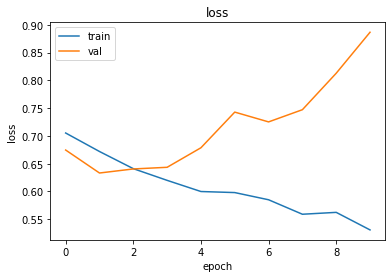

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 2, 39, 2)     0           batch_normalization_3[0][0]      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 2, 20, 24)    960         zero_padding2d_1[0][0]  

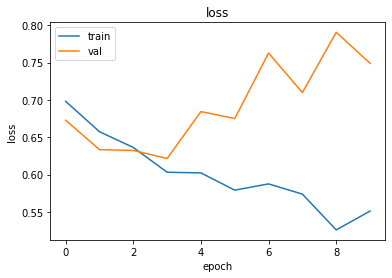

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 2, 39, 2)     0           batch_normalization_6[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 2, 20, 24)    960         zero_padding2d_2[0][0]  

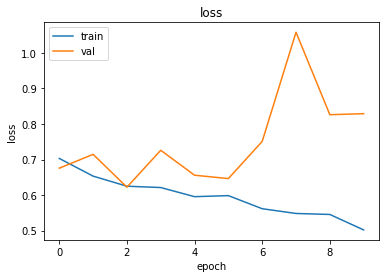

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 2, 39, 2)     0           batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 2, 20, 24)    960         zero_padding2d_3[0][0]  

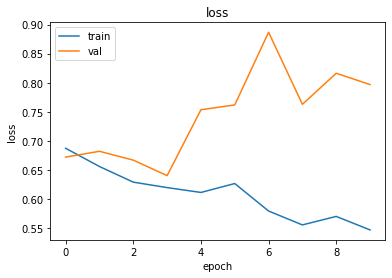

11178
avg_AUC :  0.7024281045805355
avg_AUC_2 :  0.7023358585858586
          0         1         2  ...         7         8         9
0  0.686336  0.710909  0.707465  ...  0.699267  0.681729  0.662366
1  0.718077  0.726510  0.729570  ...  0.713334  0.713398  0.697958
2  0.694364  0.711250  0.733635  ...  0.683503  0.698008  0.702690
3  0.712763  0.726986  0.736704  ...  0.729985  0.729679  0.745784

[4 rows x 10 columns]
0    0.702885
1    0.718914
2    0.726844
3    0.723738
4    0.726137
5    0.721830
6    0.715919
7    0.706522
8    0.705703
9    0.702200
dtype: float64
init A shape:  (52402, 111)
(44712, 2, 15) (44712, 2, 20, 2) 131.0
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2

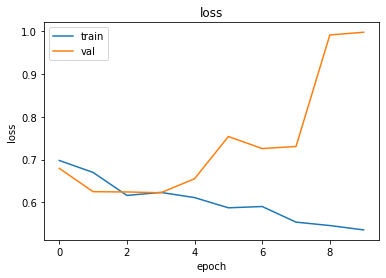

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 2, 39, 2)     0           batch_normalization_15[0][0]     
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 2, 20, 24)    960         zero_padding2d_5[0][0]  

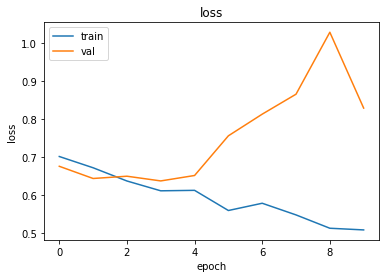

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 2, 39, 2)     0           batch_normalization_18[0][0]     
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 2, 20, 24)    960         zero_padding2d_6[0][0]  

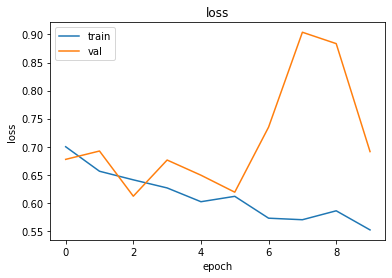

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 2, 39, 2)     0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 2, 20, 24)    960         zero_padding2d_7[0][0]  

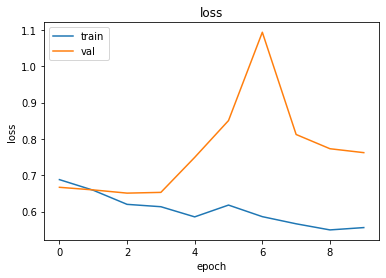

11178
avg_AUC :  0.7015491150854956
avg_AUC_2 :  0.701934113865932
          0         1         2  ...         7         8         9
0  0.691497  0.720298  0.722790  ...  0.704078  0.689772  0.689057
1  0.727095  0.725545  0.725395  ...  0.706678  0.701381  0.693517
2  0.678920  0.705359  0.759366  ...  0.697148  0.698373  0.706054
3  0.723720  0.744004  0.745335  ...  0.712113  0.700914  0.713415

[4 rows x 10 columns]
0    0.705308
1    0.723801
2    0.738222
3    0.727901
4    0.725080
5    0.723175
6    0.715270
7    0.705004
8    0.697610
9    0.700511
dtype: float64
init A shape:  (52402, 111)
(44712, 2, 15) (44712, 2, 20, 2) 131.0
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2,

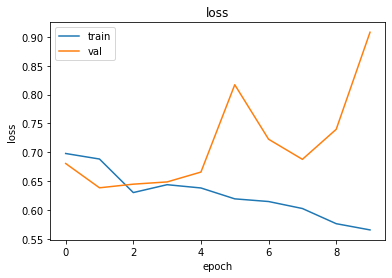

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_9 (ZeroPadding2D (None, 2, 39, 2)     0           batch_normalization_27[0][0]     
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 2, 20, 24)    960         zero_padding2d_9[0][0]  

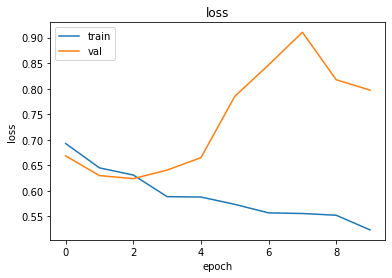

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_30[0][0]     
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 2, 20, 24)    960         zero_padding2d_10[0][0] 

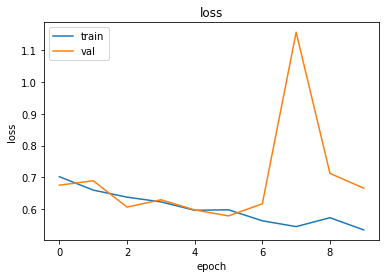

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 2, 20, 24)    960         zero_padding2d_11[0][0] 

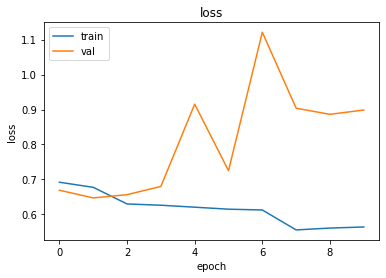

11178
avg_AUC :  0.6950696576674668
avg_AUC_2 :  0.6948294498010408
          0         1         2  ...         7         8         9
0  0.653511  0.702709  0.722013  ...  0.716197  0.708051  0.678982
1  0.718654  0.715016  0.722292  ...  0.681777  0.691670  0.668120
2  0.700886  0.708316  0.756863  ...  0.668040  0.707238  0.707858
3  0.718509  0.738101  0.747222  ...  0.715156  0.694631  0.719397

[4 rows x 10 columns]
0    0.697890
1    0.716035
2    0.737098
3    0.731572
4    0.727442
5    0.723527
6    0.717951
7    0.695293
8    0.700398
9    0.693589
dtype: float64
init A shape:  (52402, 111)
(44712, 2, 15) (44712, 2, 20, 2) 131.0
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2

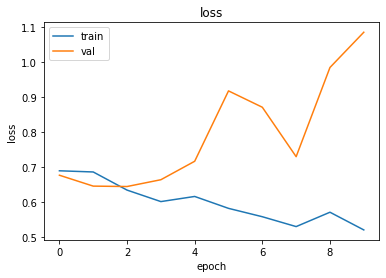

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_39[0][0]     
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 2, 20, 24)    960         zero_padding2d_13[0][0] 

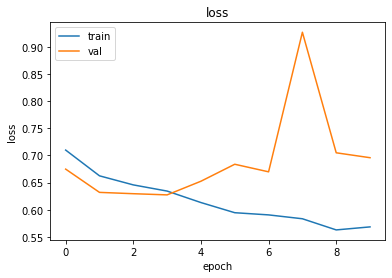

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_14 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 2, 20, 24)    960         zero_padding2d_14[0][0] 

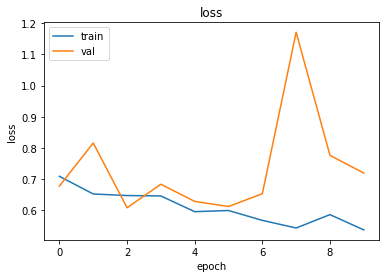

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_15 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_45[0][0]     
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 2, 20, 24)    960         zero_padding2d_15[0][0] 

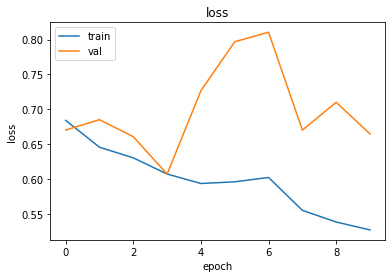

11178
avg_AUC :  0.7076348889170649
avg_AUC_2 :  0.7075274525558617
          0         1         2  ...         7         8         9
0  0.681651  0.703743  0.700515  ...  0.690723  0.680987  0.667908
1  0.711598  0.727183  0.739819  ...  0.711628  0.741951  0.739662
2  0.685504  0.686166  0.746375  ...  0.676999  0.701490  0.677825
3  0.720953  0.715778  0.739700  ...  0.734160  0.720708  0.741638

[4 rows x 10 columns]
0    0.699926
1    0.708218
2    0.731602
3    0.731069
4    0.725515
5    0.720515
6    0.716759
7    0.703377
8    0.711284
9    0.706758
dtype: float64
init A shape:  (52402, 111)
(44712, 2, 15) (44712, 2, 20, 2) 131.0
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2

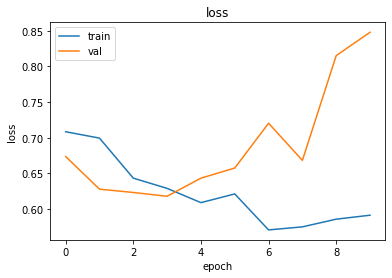

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_17 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_51[0][0]     
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 2, 20, 24)    960         zero_padding2d_17[0][0] 

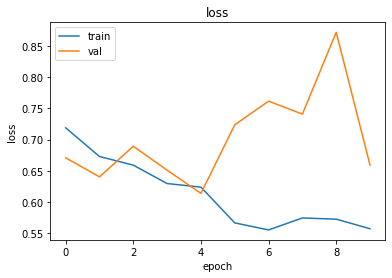

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_54[0][0]     
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 2, 20, 24)    960         zero_padding2d_18[0][0] 

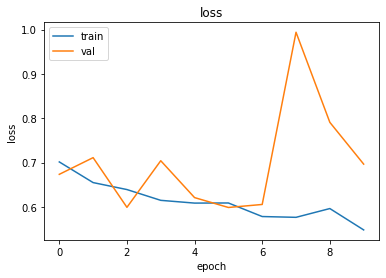

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_57[0][0]     
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 2, 20, 24)    960         zero_padding2d_19[0][0] 

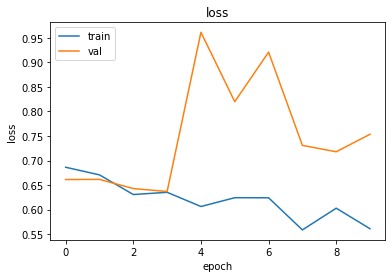

11178
avg_AUC :  0.7045143484664779
avg_AUC_2 :  0.7046532096678448
          0         1         2  ...         7         8         9
0  0.695904  0.718041  0.720868  ...  0.727678  0.715052  0.695366
1  0.718562  0.720256  0.723474  ...  0.716976  0.726495  0.718879
2  0.716684  0.724242  0.755131  ...  0.659877  0.695193  0.685830
3  0.722788  0.727406  0.737686  ...  0.716279  0.704838  0.714905

[4 rows x 10 columns]
0    0.713484
1    0.722486
2    0.734290
3    0.732358
4    0.728212
5    0.724001
6    0.724330
7    0.705203
8    0.710395
9    0.703745
dtype: float64
init A shape:  (52402, 111)
(44712, 2, 15) (44712, 2, 20, 2) 131.0
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2

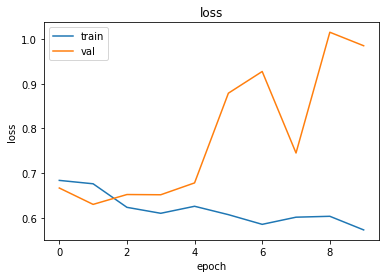

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_21 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_63[0][0]     
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 2, 20, 24)    960         zero_padding2d_21[0][0] 

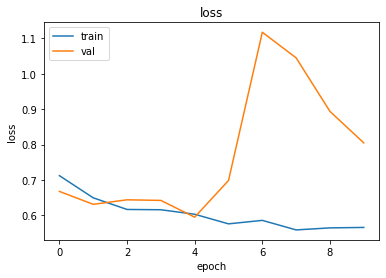

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_66 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_22 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_66[0][0]     
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 2, 20, 24)    960         zero_padding2d_22[0][0] 

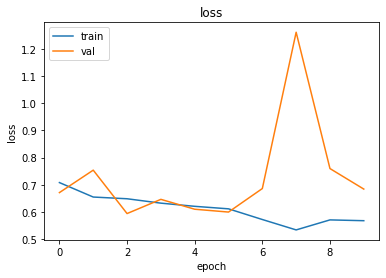

11178
shape after padding: (None, 2, 39, 2)
conv shape: (None, 2, 20, 24)
pool shape: (None, 2, 24)
Model: "model_tcn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words (InputLayer)        [(None, 2, 20, 2)]   0                                            
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 2, 20, 2)     8           input_words[0][0]                
__________________________________________________________________________________________________
zero_padding2d_23 (ZeroPadding2 (None, 2, 39, 2)     0           batch_normalization_69[0][0]     
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 2, 20, 24)    960         zero_padding2d_23[0][0] 

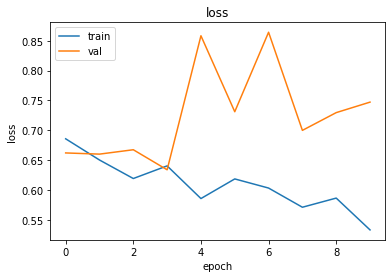

11178
avg_AUC :  0.7084022357301895
avg_AUC_2 :  0.7079770240281603
          0         1         2  ...         7         8         9
0  0.709341  0.712167  0.701336  ...  0.707577  0.705899  0.675842
1  0.724423  0.724771  0.725840  ...  0.705800  0.723406  0.714623
2  0.721677  0.704465  0.758874  ...  0.666455  0.711107  0.690214
3  0.723372  0.732507  0.744075  ...  0.751285  0.713561  0.741705

[4 rows x 10 columns]
0    0.719703
1    0.718477
2    0.732531
3    0.733278
4    0.732983
5    0.727595
6    0.716410
7    0.707779
8    0.713493
9    0.705596
dtype: float64


In [36]:
filter = [24,28,32,36,46,56]
for f in filter:
  w = 2
  perf_cols = v_perf + v_1
  words_cols = selected_new_all_sorted
  label = 'label'
  h = cross_val( df_fl, 'label', \
            perf_cols,\
            words_cols, \
            'model_tcn_w2',w, \
            filters = f)